In [198]:
import results
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import glob

sns.set(style = "whitegrid", rc = {
   "legend.frameon": False,
    "font.family": "DejaVu Sans",
    "font.sans-serif": "Helvetica",
    "axes.titlesize": 14,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.labelsize": 16,
    'legend.fontsize': 12
})


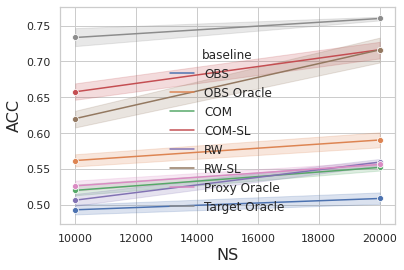

In [205]:
df, meandf  = results.get_erm_convergence_result_df('NR_erm_convergence_rates_crossfit_oracle_R10')

df = df[df['alpha_0'] == 0.4]
df.reset_index(inplace=True)
fig = sns.lineplot(data=df, x="NS", y="ACC", hue='baseline', ci=68, marker='o')

,index,Unnamed: 0,alpha_0,alpha_1,beta_0,beta_1,alpha_0_hat,beta_0_hat,benchmark,NS,AU-ROC,ACC,do,baseline
0,0,0,0.0,0,0.4,0,0.0,0.4,synthetic_1D_sinusoidal,20000,0.605007,0.563667,0,OBS
1,1,1,0.0,0,0.4,0,0.0,0.4,synthetic_1D_sinusoidal,20000,0.608074,0.545167,0,OBS Oracle
2,2,2,0.0,0,0.4,0,0.0,0.4,synthetic_1D_sinusoidal,20000,0.807444,0.512500,0,COM
3,3,3,0.0,0,0.4,0,0.0,0.4,synthetic_1D_sinusoidal,20000,0.692061,0.661667,0,COM-SL
4,4,4,0.0,0,0.4,0,0.0,0.4,synthetic_1D_sinusoidal,20000,0.708235,0.512500,0,RW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,75,75,0.0,0,0.4,0,0.0,0.4,synthetic_1D_sinusoidal,10000,0.701893,0.683667,0,COM-SL
476,76,76,0.0,0,0.4,0,0.0,0.4,synthetic_1D_sinusoidal,10000,0.712305,0.516667,0,RW
477,77,77,0.0,0,0.4,0,0.0,0.4,synthetic_1D_sinusoidal,10000,0.697899,0.707000,0,RW-SL
478,78,78,0.0,0,0.4,0,0.0,0.4,synthetic_1D_sinusoidal,10000,0.769174,0.516667,0,Proxy Oracle


In [165]:
df.groupby(['NS', 'baseline']).std()

index  Unnamed: 0  alpha_0  alpha_1  beta_0  beta_1  \
NS    baseline                                                                 
5000  COM            28.284271   28.284271      0.0      0.0     0.0     0.0   
      COM-SL         26.273289   26.273289      0.0      0.0     0.0     0.0   
      OBS            26.432303   26.432303      0.0      0.0     0.0     0.0   
      OBS Oracle     28.284271   28.284271      0.0      0.0     0.0     0.0   
      Proxy Oracle   28.751812   28.751812      0.0      0.0     0.0     0.0   
      RW             27.491990   27.491990      0.0      0.0     0.0     0.0   
      RW-SL          26.273289   26.273289      0.0      0.0     0.0     0.0   
      Target Oracle  24.221203   24.221203      0.0      0.0     0.0     0.0   
15000 COM            25.657079   25.657079      0.0      0.0     0.0     0.0   
      COM-SL         24.221203   24.221203      0.0      0.0     0.0     0.0   
      OBS            28.000000   28.000000      0.0      0.0     0.0     0.0   
      OBS Oracle     23.475756   23.475756      0.0      0.0     0.0     0.0   
      Proxy Oracle   23.475756   23.475756      0.0      0.0     0.0     0.0   
      RW             24.221203   24.221203      0.0      0.0     0.0     0.0   
      RW-SL          25.298221   25.298221      0.0      0.0     0.0     0.0   
      Target Oracle  22.526175   22.526175      0.0      0.0     0.0     0.0   
25000 COM            23.475756   23.475756      0.0      0.0     0.0     0.0   
      COM-SL         25.647179   25.647179      0.0      0.0     0.0     0.0   
      OBS            21.614810   21.614810      0.0      0.0     0.0     0.0   
      OBS Oracle     22.559973   22.559973      0.0      0.0     0.0     0.0   
      Proxy Oracle   27.558423   27.558423      0.0      0.0     0.0     0.0   
      RW             23.421602   23.421602      0.0      0.0     0.0     0.0   
      RW-SL          21.908902   21.908902      0.0      0.0     0.0     0.0   
      Target Oracle  24.221203   24.221203      0.0      0.0     0.0     0.0   
30000 COM            21.908902   21.908902      0.0      0.0     0.0     0.0   
      COM-SL         24.221203   24.221203      0.0      0.0     0.0     0.0   
      OBS            12.649111   12.649111      0.0      0.0     0.0     0.0   
      OBS Oracle     26.010987   26.010987      0.0      0.0     0.0     0.0   
      Proxy Oracle   25.298221   25.298221      0.0      0.0     0.0     0.0   
      RW             23.475756   23.475756      0.0      0.0     0.0     0.0   
      RW-SL          27.712813   27.712813      0.0      0.0     0.0     0.0   
      Target Oracle  24.221203   24.221203      0.0      0.0     0.0     0.0   

                     alpha_0_hat  beta_0_hat    AU-ROC       ACC   do  
NS    baseline                                                         
5000  COM               0.037642    0.037677  0.054045  0.020990  0.0  
      COM-SL            0.030953    0.055597  0.066114  0.020942  0.0  
      OBS               0.100826    0.038092  0.030831  0.046112  0.0  
      OBS Oracle        0.184908    0.036358  0.027414  0.004243  0.0  
      Proxy Oracle      0.140187    0.027172  0.022793  0.019020  0.0  
      RW                0.106758    0.033737  0.057094  0.015197  0.0  
      RW-SL             0.030953    0.055597  0.063548  0.026478  0.0  
      Target Oracle     0.099433    0.051990  0.065428  0.040899  0.0  
15000 COM               0.076597    0.127759  0.106879  0.059991  0.0  
      COM-SL            0.084102    0.127496  0.074331  0.079482  0.0  
      OBS               0.094296    0.135521  0.055905  0.036022  0.0  
      OBS Oracle        0.086234    0.133745  0.042019  0.036638  0.0  
      Proxy Oracle      0.086234    0.133745  0.077297  0.057225  0.0  
      RW                0.084102    0.127496  0.072215  0.067060  0.0  
      RW-SL             0.080063    0.130491  0.068781  0.074435  0.0  
      Target Oracle     0.088795    0.130242  0.080650  0.055857  0.0  
25000 CO

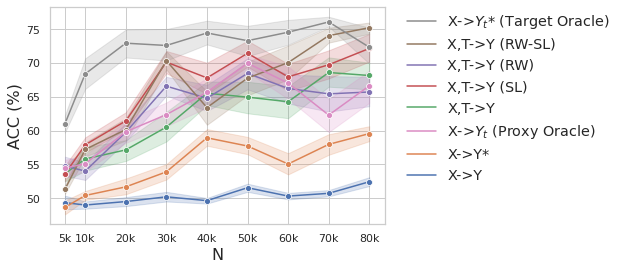

In [107]:
df, meandf  = results.get_erm_convergence_result_df('erm_convergence_rates_no_crossfit_beta3_alpha1_R15')
df['ACC']= df['ACC']*100
df.reset_index(inplace=True)

fig = sns.lineplot(data=df, x="NS", y="ACC", hue='baseline', ci=68, marker='o')
fig.set_xlabel('N')
fig.set_ylabel('ACC (%)')

handles, labels = plt.gca().get_legend_handles_labels()

disp_names = {
    'Target Oracle': 'X->$Y_t$* (Target Oracle)',
    'RW-SL': 'X,T->Y (RW-SL)',
    'COM-SL': 'X,T->Y (SL)',
    'COM': 'X,T->Y',
    'RW': 'X,T->Y (RW)',
    'Proxy Oracle': 'X->$Y_t$ (Proxy Oracle)',
    'OBS Oracle': 'X->Y*',
    'OBS': 'X->Y'
}
order = [7,5,4,3,2,6,1,0]
plt.legend([handles[idx] for idx in order],[disp_names[labels[idx]] for idx in order],
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='large')

fig.set_xticks([5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000], labels=['5k', '10k', '20k', '30k', '40k', '50k', '60k', '70k', '80k'])


In [124]:
avg([1,2,3]

NameError: name 'avg' is not defined

In [75]:
df[(df['baseline'] == 'Proxy Oracle') & (df['NS'] == 70000)]

,index,Unnamed: 0,alpha_0,alpha_1,beta_0,beta_1,alpha_0_hat,beta_0_hat,benchmark,NS,AU-ROC,ACC,do,baseline
606,6,6,0.1,0,0.3,0,0.124649,0.383452,synthetic_1D_sinusoidal,70000,0.762380,60.128571,0,Proxy Oracle
614,14,14,0.1,0,0.3,0,0.101299,0.244238,synthetic_1D_sinusoidal,70000,0.500000,49.919048,0,Proxy Oracle
622,22,22,0.1,0,0.3,0,0.081069,0.294413,synthetic_1D_sinusoidal,70000,0.760853,60.561905,0,Proxy Oracle
630,30,30,0.1,0,0.3,0,0.072542,0.355020,synthetic_1D_sinusoidal,70000,0.839937,71.895238,0,Proxy Oracle
638,38,38,0.1,0,0.3,0,0.232452,0.466959,synthetic_1D_sinusoidal,70000,0.845575,73.476190,0,Proxy Oracle
646,46,46,0.1,0,0.3,0,0.064174,0.442797,synthetic_1D_sinusoidal,70000,0.500000,50.171429,0,Proxy Oracle
654,54,54,0.1,0,0.3,0,0.135445,0.518014,synthetic_1D_sinusoidal,70000,0.620476,59.771429,0,Proxy Oracle
662,62,62,0.1,0,0.3,0,0.073328,0.204462,synthetic_1D_sinusoidal,70000,0.841484,68.309524,0,Proxy Oracle
670,70,70,0.1,0,0.3,0,0.227672,0.440777,synthetic_1D_sinusoidal,70000,0.841878,74.042857,0,Proxy Oracle
678,78,78,0.1,0,0.3,0,0.216629,0.312750,synthetic_1D_sinusoidal,70000,0.841644,75.452381,0,Proxy Oracle


In [27]:
df['alpha_error'] = df['alpha_0'] - df['alpha_0_hat']
df['beta_error'] = df['beta_0'] - df['beta_0_hat']
df.groupby(['baseline', 'NS']).mean().to_csv('baselines.csv')

In [207]:
results = []
for f in glob.glob(f'results/NR_erm_jobs_crossfit_oracle_params_R10/*TE.csv'):
    results.append(pd.read_csv(f))
nsdf = pd.concat(results)
nsdf.drop(columns=['Unnamed: 0'], inplace=True)

nsdf['ate_error'] = nsdf['ate_hat'] - nsdf['ate']
nsdf['param'] = "(" + nsdf['alpha_0'].astype(str)+"," +nsdf['beta_0'].astype(str) + ")"

jobs = nsdf[nsdf['benchmark'] == 'jobs']
ohie = nsdf[nsdf['benchmark'] == 'ohie']
jobs = jobs.sort_values('alpha_0', ascending=True).reset_index(drop=True)
ohie = ohie.sort_values('alpha_0', ascending=True).reset_index(drop=True)

In [208]:
def plot_experimental_data_results(df, metric):
    plt.figure(figsize=(12, 6))
    g = sns.barplot(data=df, x='baseline', y=metric, hue='param', ci=68, errwidth=2)
    plt.xlabel("")
    
    ylabel = "MSE ATE" if metric == "ate_error" else "Policy Risk"
    
    plt.ylabel(ylabel)
    plt.legend( title=r"         ($\alpha, \beta$)")
#     models = ['X -> Y', 'X,T->Y (RW-SL)', 'X->$Y_t$* (Target Oracle)','X->Y*', 'X,T->Y', 'X,T->Y (SL)', 'X,T->Y (RW)', 'X->$Y_t$ (Proxy Oracle)']
#     g.set_xticks(range(len(models)), models, size=12)
#     plt.xticks(rotation=45)


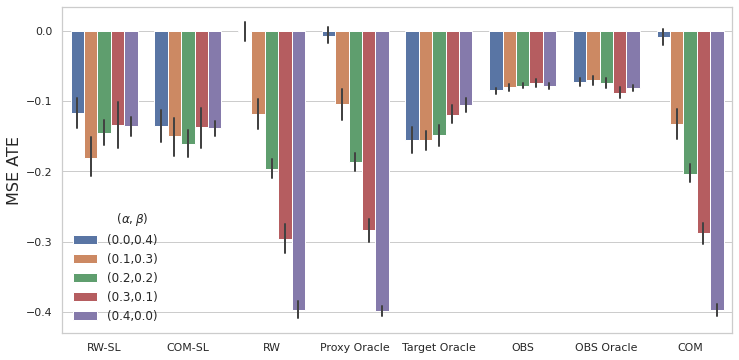

In [209]:
plot_experimental_data_results(jobs, 'ate_error')

In [ ]:
[-]

In [197]:
for i in range(-1, 1, 20):
    print(.05*i)
    
  

TypeError: 'float' object cannot be interpreted as an integer

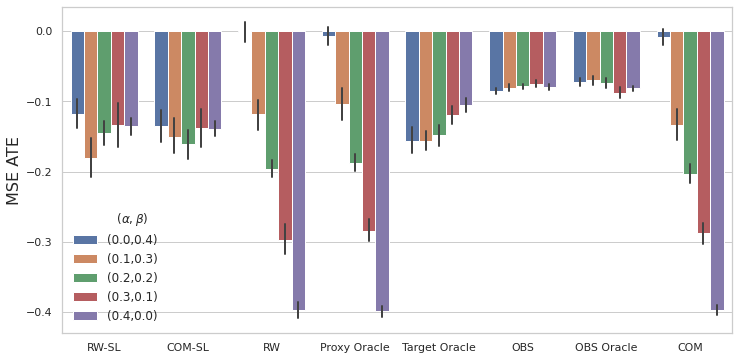

In [218]:
plot_experimental_data_results(jobs, 'ate_error')

In [211]:
jobs

,alpha_0,alpha_1,beta_0,beta_1,alpha_0_hat,beta_0_hat,alpha_1_hat,beta_1_hat,benchmark,NS,...,pr_-0.05,pr_0,pr_0.05,pr_0.1,pr_0.15,pr_0.2,pr_0.25,pr_0.3,baseline,param
0,0.0,0,0.4,0,0.0,0.4,0,0,jobs,NaN,...,0.018914,0.019966,0.019882,0.020999,0.025554,0.030543,0.039714,0.049669,RW-SL,"(0.0,0.4)"
1,0.0,0,0.4,0,0.0,0.4,0,0,jobs,NaN,...,0.008205,0.008713,0.011552,0.012926,0.017300,0.019865,0.023746,0.027707,COM-SL,"(0.0,0.4)"
2,0.0,0,0.4,0,0.0,0.4,0,0,jobs,NaN,...,0.008457,0.008262,0.009954,0.010235,0.012675,0.017408,0.023177,0.025135,RW,"(0.0,0.4)"
3,0.0,0,0.4,0,0.0,0.4,0,0,jobs,NaN,...,0.010517,0.009613,0.012585,0.012436,0.016599,0.021453,0.021614,0.025165,RW-SL,"(0.0,0.4)"
4,0.0,0,0.4,0,0.0,0.4,0,0,jobs,NaN,...,0.008376,0.008036,0.010452,0.013012,0.012413,0.018056,0.021486,0.023405,Proxy Oracle,"(0.0,0.4)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.4,0,0.0,0,0.4,0.0,0,0,jobs,NaN,...,0.017441,0.017618,0.017721,0.019962,0.023434,0.025284,0.027018,0.032476,Target Oracle,"(0.4,0.0)"
396,0.4,0,0.0,0,0.4,0.0,0,0,jobs,NaN,...,0.014309,0.044930,0.142084,0.203940,0.206258,0.206258,0.206258,0.206258,OBS,"(0.4,0.0)"
397,0.4,0,0.0,0,0.4,0.0,0,0,jobs,NaN,...,0.021522,0.039029,0.171809,0.193550,0.208629,0.206258,0.206258,0.206258,OBS Oracle,"(0.4,0.0)"
398,0.4,0,0.0,0,0.4,0.0,0,0,jobs,NaN,...,0.013087,0.012634,0.014134,0.017888,0.018544,0.021531,0.026085,0.031695,Target Oracle,"(0.4,0.0)"


Text(0, 0.5, 'Policy risk')

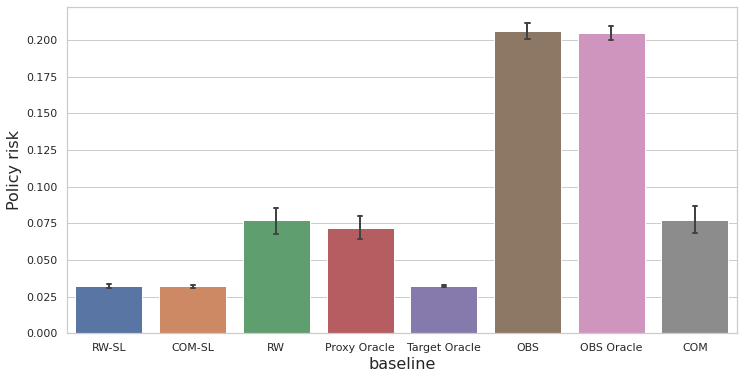

In [217]:
plt.figure(figsize=(12, 6))
g = sns.barplot(data=jobs, x='baseline', y="pr_0.2", ci=68, errwidth=2, capsize=.05)

plt.ylabel("Policy risk")
